In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.util.utils as futil
import datainterface.patient as Pat
# from fragility.signalprocessing import frequencyanalysis

import os
import time
import pickle

import numpy as np
import pandas as pd
import scipy
import scipy.io

import processing.util as util
import processing.frequencytransform as ft
import peakdetect
import processing.preprocessfft as preprocess

# sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
# import tvbsim.util

from natsort import natsorted
import ntpath
from sklearn.decomposition import PCA

import keras

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

In [7]:
expname = 'cnn'

# dirs for the training data from the model 
datadir = os.path.join('/Volumes/ADAM LI/pydata/dnn/', expname)
tempdir = os.path.join(datadir, '_temp')
finaldir = os.path.join(datadir, '_final')
finalhistfile = os.path.join(finaldir, 'finalhistory')

# the original raw data dir
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    
fftdir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fft/', expname)

# the training data dir
traindatadir = '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/'
# Get ALL datafiles from all downstream files
trainfiles = []
for root, dirs, files in os.walk(traindatadir):
    for file in files:
        trainfiles.append(os.path.join(root, file))
print("Train data dir is: ", datadir)
print("In traindatadir there are this many training files: ", len(trainfiles))


# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
print("Data dir is: ", datadir)
print("In datadir there are this many training files: ", len(datafiles))
# print(datafiles[50:])
# print(datafiles)
print("\n\n", datafiles[0:5])

Train data dir is:  /Volumes/ADAM LI/pydata/dnn/cnn
In traindatadir there are this many training files:  237
Data dir is:  /Volumes/ADAM LI/pydata/dnn/cnn
In datadir there are this many training files:  253


 ['/Volumes/ADAM LI/pydata/dnn/cnn/_temp/weights-improvement-02-0.94.hdf5', '/Volumes/ADAM LI/pydata/dnn/cnn/_temp/weights-improvement-109.h5', '/Volumes/ADAM LI/pydata/dnn/cnn/_temp/weights-improvement-158.h5', '/Volumes/ADAM LI/pydata/dnn/cnn/_temp/weights-improvement-31.h5', '/Volumes/ADAM LI/pydata/dnn/cnn/_temp/weights-improvement-60.h5']


# Test How Much Data Can Fit Into Memory

Load in the data and concatenate to get examples.

In [8]:
for idx, datafile in enumerate(trainfiles):
    data = np.load(datafile)
    imagetensor = data['image_tensor']
    metadata = data['metadata'].item()
    labels = metadata['ylabels']
    
    if idx == 0:
        ylabels = labels
        alltensors = imagetensor.reshape((imagetensor.shape[0], -1))
        print(datafile)
        print(imagetensor.shape)
        print(metadata.keys())
    else:
        alltensors = np.concatenate((alltensors, imagetensor.reshape((imagetensor.shape[0], -1))), axis=0)
        ylabels = np.concatenate((ylabels, metadata['ylabels']),axis=0)  
        
#     if idx == 0:
#         buff = imagetensor.reshape((1,imagetensor.shape[0],-1))
#         print(buff.shape)
#         alltensors = keras.preprocessing.sequence.pad_sequences(buff, maxlen=500, 
#             dtype='float64', padding='pre', truncating='pre', value=0.)
#         ylabels = keras.preprocessing.sequence.pad_sequences(labels.reshape((1,-1)), maxlen=500,
#                             padding='pre', truncating='pre', value=0.)
#         print(buff.shape)
#         print(ylabels.shape)
#         print(datafile)
#         print(imagetensor.shape)
#         print(metadata.keys())
#     else:
#         buff = imagetensor.reshape((1,imagetensor.shape[0],-1))
#         buff = keras.preprocessing.sequence.pad_sequences(buff, maxlen=500, 
#             dtype='float64', padding='pre', truncating='pre', value=0.)
#         alltensors = np.concatenate((alltensors, buff), axis=0)
        
#         labels = keras.preprocessing.sequence.pad_sequences(labels.reshape((1,-1)), maxlen=500,
#                             padding='pre', truncating='pre', value=0.)
#         ylabels = np.concatenate((ylabels, labels),axis=0)  
        
#         print(alltensors.shape)
#         print(ylabels.shape)
#         break
#     if idx == 10:
#         break
#     break

/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_0.npz
(239, 4, 32, 32)
dict_keys(['x0ez', 'seeg_contacts', 'new_locs', 'ylabels'])


In [10]:
print(sys.getsizeof(alltensors) * 1.0e-9) 
print(alltensors.shape)
print(ylabels.shape)

filename = os.path.join(traindatadir, 'allimages_2d.npz')
np.savez_compressed(filename, images=alltensors, labels=ylabels)

2.1171733600000002
(64611, 4096)
(64611, 1)


In [18]:
# the training data dir
traindatadir = '/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/'
# Get ALL datafiles from all downstream files
trainfiles = []
for root, dirs, files in os.walk(traindatadir):
    for file in files:
        trainfiles.append(os.path.join(root, file))
print("Train data dir is: ", traindatadir)
print("In traindatadir there are this many training files: ", len(trainfiles))

ylabels = []
all3dtensors = []
for idx, datafile in enumerate(trainfiles):
    data = np.load(datafile)
    imagetensor = data['image_tensor']
    metadata = data['metadata'].item()
    
    all3dtensors.append(imagetensor.reshape((imagetensor.shape[0],-1)))
    ylabels.append(metadata['ylabels'])
    print(imagetensor.shape)
#     if idx == 0:
#         all3dtensors = imagetensor.reshape([imagetensor.shape[0],-1])
#         ylabels = metadata['ylabels']
#         print(datafile)
#         print(imagetensor.shape)
#         print(metadata.keys())
#     else:
#         all3dtensors = np.concatenate((all3dtensors, imagetensor.reshape([imagetensor.shape[0],-1])), axis=0)
#         ylabels = np.concatenate((ylabels, metadata['ylabels']),axis=0)
        
    if idx == 5:
        break
#     break

Train data dir is:  /Volumes/ADAM LI/pydata/dnn/traindata/image_3d/
In traindatadir there are this many training files:  233
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_0.npz
(239, 4, 32, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_1.npz
(239, 4, 32, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_2.npz
(239, 4, 32, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_3.npz
(239, 4, 32, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_4.npz
(239, 4, 32, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/image_3d/allregions_moved/id001_ac_nez1_npz1_5.npz
(239, 4, 32, 32, 32)


In [14]:
print(len(ylabels))
test=ylabels[1]
print(test.shape)
test = np.asarray(ylabels)
print(test.shape)

11
(239, 1)
(11, 239, 1)


In [11]:
ylabels = np.asarray(ylabels)
print(ylabels.shape)

all3dtensors = np.asarray(all3dtensors)
print(all3dtensors.shape)

(101, 239, 1)
(101, 239, 131072)


In [68]:
print(sys.getsizeof(all3dtensors)* 1.0e-9)
print(all3dtensors.shape)
print(ylabels.shape)
# test = test.reshape([-1, 4, 32, 32, 32])
# print(test.shape)

39.846936704
(38001, 4, 32768)
(22541, 1)


In [49]:
print(sys.getsizeof(all3dtensors) * 1.0e-9) 
print(all3dtensors.shape)
print(ylabels.shape)

filename = os.path.join(traindatadir, 'allimages_3d.npz')
np.savez_compressed(filename, images=all3dtensors, labels=ylabels)

1.9524814240000001
(26051, 4, 32, 32, 32)
(26051, 1)


OSError: [Errno 27] File too large

# Visualize Final History

Investigate the history object saved at the final point in time and see how training proceeded. Get a value of the accuracy and precision of the neural network.

Visualize any other important metadata.

In [6]:
expname = 'test_2dcnn_fragility'
outputdatadir = os.path.join('/Volumes/ADAM LI/pydata/dnn/output/', expname)
finalhistfile = os.path.join(outputdatadir, 'history_2dcnn.pkl')

In [7]:
print(finalhistfile)
# hist = pickle.load(finalhistfile)
H = np.load(finalhistfile)
print(H.keys())

/Volumes/ADAM LI/pydata/dnn/output/test_2dcnn_fragility/history_2dcnn.pkl
dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


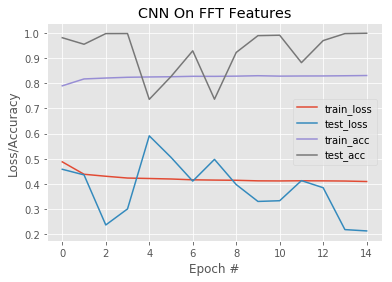

In [13]:
# plot the training loss and accuracy
N = np.arange(0, len(H["loss"][0:15]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H["loss"][0:15], label="train_loss")
plt.plot(N, H["val_loss"][0:15], label="test_loss")
plt.plot(N, H["acc"][0:15], label="train_acc")
plt.plot(N, H["val_acc"][0:15], label="test_acc")
plt.title("CNN On FFT Features")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# print(model.summary())

# Visualize The Diversity of the Data That We Used

Visualize the diversity of the data we used to train the model.

In [11]:
# print(H['val_acc'])
print(len(H))

4
